In [1]:
import pandas as pd
from datetime import datetime
import re



In [2]:
PARTNER_CONFIG = {
    "acme": {
        "partner_code": "ACME",
        "file_path": "acme health.txt",
        "delimiter": "|",
        "column_mapping": {
            "MBI": "external_id",
            "FNAME": "first_name",
            "LNAME": "last_name",
            "DOB": "dob",
            "EMAIL": "email",
            "PHONE": "phone"
        },
        "dob_formats": ["%m/%d/%Y"]
    },
    "bettercare": {
        "partner_code": "BETTERCARE",
        "file_path": "bettercare.csv",
        "delimiter": ",",
        "column_mapping": {
            "subscriber_id": "external_id",
            "first_name": "first_name",
            "last_name": "last_name",
            "date_of_birth": "dob",
            "email": "email",
            "phone": "phone"
        },
        "dob_formats": ["%m/%d/%Y"]
    }
}


In [3]:

def read_partner_file(path, delimiter):
    return pd.read_csv(
        path,
        delimiter=delimiter,
        dtype=str,
        skip_blank_lines=True
    )


In [4]:
def init_error_df():
    return pd.DataFrame(
        columns=["partner_code", "row_number", "external_id", "field", "error"]
    )


In [5]:
def format_phone(phone):
    if pd.isna(phone):
        return None
    digits = re.sub(r"\D", "", str(phone))
    if len(digits) == 10:
        return f"{digits[:3]}-{digits[3:6]}-{digits[6:]}"
    return None


In [6]:
def parse_dob(value, formats, row_idx, partner_code, error_df):
    if pd.isna(value):
        return None

    value = str(value).strip()

    for fmt in formats:
        try:
            return datetime.strptime(value, fmt).strftime("%Y-%m-%d")
        except ValueError:
            continue

    error_df.loc[len(error_df)] = [
        partner_code,
        row_idx,
        None,
        "dob",
        f"Invalid date format: {value}"
    ]
    return None


In [7]:
def process_partner(df, config, error_df, drop_invalid=True):
    
    df = df.rename(columns=config["column_mapping"])
    df = df[list(config["column_mapping"].values())]

    
    df["first_name"] = df["first_name"].str.title()
    df["last_name"] = df["last_name"].str.title()
    df["email"] = df["email"].str.lower()
    df["phone"] = df["phone"].apply(format_phone)

    
    df["dob"] = [
        parse_dob(val, config["dob_formats"], idx, config["partner_code"], error_df)
        for idx, val in enumerate(df["dob"])
    ]

 
    df["partner_code"] = config["partner_code"]

  
    missing_id_mask = df["external_id"].isna()

    for idx in df[missing_id_mask].index:
        error_df.loc[len(error_df)] = [
            config["partner_code"],
            idx,
            None,
            "external_id",
            "Missing external_id"
        ]

    if drop_invalid:
        df = df[~missing_id_mask]

    return df


In [8]:
error_df = init_error_df()
standardized_dfs = []

for partner, config in PARTNER_CONFIG.items():
    raw_df = read_partner_file(
        config["file_path"],
        config["delimiter"]
    )

    standardized_df = process_partner(
        raw_df,
        config,
        error_df
    )

    standardized_dfs.append(standardized_df)



In [9]:
unified_df = pd.concat(standardized_dfs, ignore_index=True)
unified_df



,external_id,first_name,last_name,dob,email,phone,partner_code
0,1234567890A,John,Doe,1955-03-15,john.doe@email.com,555-123-4567,ACME
1,9876543210B,Jane,Smith,1948-07-22,jane.smith@email.com,555-987-6543,ACME
2,BC-001,Alice,Johnson,1965-08-10,alice.j@test.com,555-222-3333,BETTERCARE
3,BC-002,Charlie,Brown,1972-03-25,charlie.b@test.com,555-444-5555,BETTERCARE


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


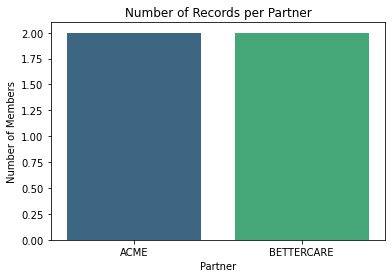

In [11]:
partner_counts = unified_df['partner_code'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=partner_counts.index, y=partner_counts.values, palette="viridis")
plt.title("Number of Records per Partner")
plt.ylabel("Number of Members")
plt.xlabel("Partner")
plt.show()
